In [1]:
import os
import optuna
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model
from dotenv import load_dotenv
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
load_dotenv()

/home/codespace/.cache/pypoetry/virtualenvs/stock-volatility-prediction-MrqSbHyr-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# Global Variables
api_key = os.getenv('FMP_API_KEY')
ticker = 'NVDA'
start_date = '2018-01-01'
end_date = '2024-01-01'

In [3]:
url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={start_date}&to={end_date}&apikey={api_key}"
response = requests.get(url).json()

In [4]:
data = pd.DataFrame(response["historical"])
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date').reset_index(drop=True)
data["return"] = data["close"].pct_change()
data.dropna(inplace=True)
data["return_squared"] = data["return"] ** 2
data["realized_vol"] = data["return"].rolling(window=5).std()
# data.reset_index(drop=True, inplace=True)
# data = data.iloc[1:].reset_index(drop=True)

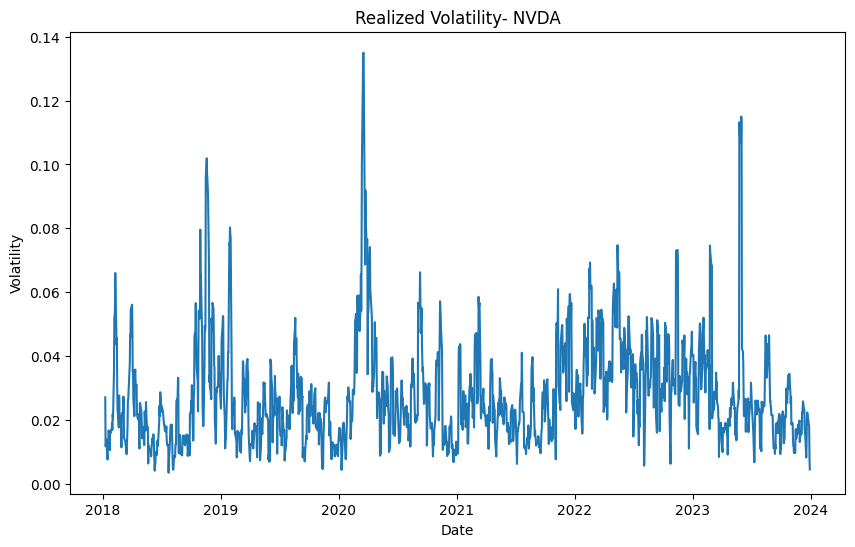

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(data["date"], data["realized_vol"])
plt.title('Realized Volatility- NVDA')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [6]:
df = (
    data[["open", "high", "low", "close", "adjClose","changePercent","vwap","return","return_squared", "realized_vol"]].copy()
    .dropna()
    # .dropna()
    .reset_index(drop=True)
)
df.dropna(inplace=True)

In [7]:
df

,open,high,low,close,adjClose,changePercent,vwap,return,return_squared,realized_vol
0,55.56,55.96,54.66,55.49,54.90,-0.125999,55.37,-0.000180,3.246490e-08,0.027157
1,54.55,55.96,54.00,55.92,55.33,2.511456,55.29,0.007749,6.004923e-05,0.011820
2,56.25,56.57,55.80,56.02,55.43,-0.408889,56.13,0.001788,3.197906e-06,0.012290
3,55.90,56.25,55.33,55.74,55.16,-0.277286,55.78,-0.004998,2.498215e-05,0.013983
4,56.01,56.88,54.17,55.03,54.45,-1.758538,55.36,-0.012738,1.622493e-04,0.007689
...,...,...,...,...,...,...,...,...,...,...
1499,491.95,493.83,484.67,488.30,488.28,-0.741950,488.93,-0.003266,1.066658e-05,0.021960
1500,489.68,496.00,489.60,492.79,492.77,0.635112,492.80,0.009195,8.455109e-05,0.018554
1501,495.11,496.80,490.85,494.17,494.15,-0.189851,493.94,0.002800,7.842137e-06,0.018309
1502,496.43,498.84,494.12,495.22,495.20,-0.243739,496.06,0.002125,4.514668e-06,0.008242


In [8]:
garch = arch_model(df["return"], mean='zero', vol='GARCH', p=1, o=0, q=1)\
                 .fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                3115.73
Distribution:                  Normal   AIC:                          -6225.46
Method:            Maximum Likelihood   BIC:                          -6209.51
                                        No. Observations:                 1504
Date:                Thu, Apr 25 2024   Df Residuals:                     1504
Time:                        06:20:08   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1002e-05  2.789e-06      7.531  5.020e-14 [1.

In [9]:
bic_garch = []

for p in range(1, 10):
    for q in range(1, 10):
        garch = arch_model(df["return"], mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q

print(f'Best BIC: {np.min(bic_garch)}')
print(f'Best Parameters: {best_param}')

garch = arch_model(df["return"], mean='zero', vol='GARCH',
                p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())

Best BIC: -6217.865351695152
Best Parameters: (2, 1)
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                3123.56
Distribution:                  Normal   AIC:                          -6239.13
Method:            Maximum Likelihood   BIC:                          -6217.87
                                        No. Observations:                 1504
Date:                Thu, Apr 25 2024   Df Residuals:                     1504
Time:                        06:20:14   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega

In [10]:
n = int(len(df) * 0.7)
print(n)

svr_rbf = SVR(kernel='rbf')
forecast = garch.forecast(start=0, horizon=5)
forecast_garch = forecast

1052


In [13]:
df = pd.concat([df, np.sqrt(forecast_garch.variance)], axis=1)

In [ ]:
# df["response"] = df["realized_vol"].shift(-5)
# df.dropna(inplace=True)

In [ ]:
df

In [14]:
import tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model

2024-04-25 06:21:11.152580: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 06:21:11.155967: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 06:21:11.220841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 06:21:12.335141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(
            df.drop(["realized_vol"],axis=1).to_numpy()
        )
        # X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
y = df["realized_vol"].to_numpy()

In [16]:
window_size = 5
n_steps = 1  # Define your forward-looking time step
feature_sequences = []
response_sequences = []

for i in range(len(X_scaled) - window_size - n_steps + 1):  # Adjust the range to account for the forward-looking time step
    feature_sequences.append(X_scaled[i : i + window_size])

    response_sequences.append(y[i + window_size + n_steps - 1])  # Adjust the target index to look ahead by n_steps

In [18]:
feature_sequences = np.array(feature_sequences)
response_sequences = np.array(response_sequences)

feature_sequences_train = feature_sequences[:n]
feature_sequences_test = feature_sequences[n:]

response_sequences_train = response_sequences[:n]
response_sequences_test = response_sequences[n:]


In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(feature_sequences_train.shape[1], feature_sequences_train.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model
history = model.fit(feature_sequences_train, response_sequences_train, epochs=50, validation_data=(feature_sequences_test, response_sequences_test))

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0010 - val_loss: 3.5829e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2870e-04 - val_loss: 2.1800e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1966e-05 - val_loss: 2.2623e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5356e-05 - val_loss: 1.4941e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7404e-05 - val_loss: 1.8835e-04
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7127e-05 - val_loss: 1.3884e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8031e-05 - val_loss: 1.8539e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2432e-05 - val_loss: 1.1830e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5492e-05 - val_loss: 1.0493e-04
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0039e-05 - val_loss: 1.8657e-04
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7159e-05 - val_loss: 1

In [20]:
prediction = model.predict(feature_sequences_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [28]:
np.sqrt(mean_squared_error(response_sequences_test, prediction))

0.011359779674665825

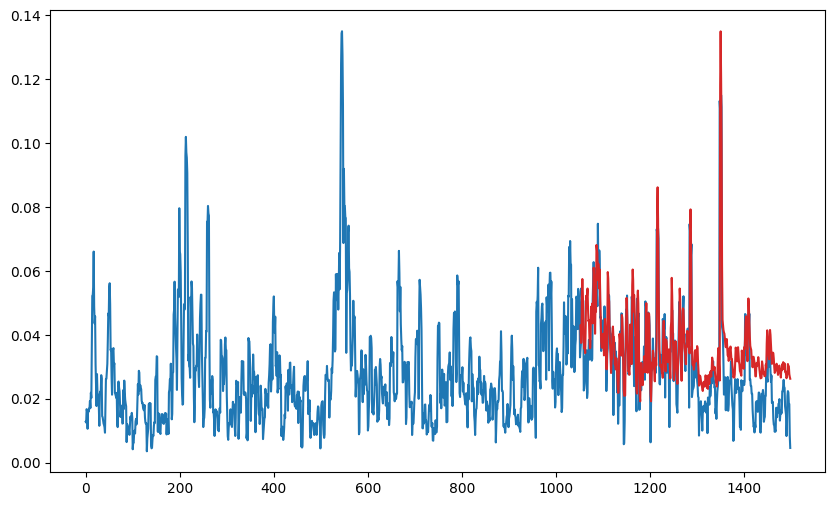

In [26]:
padded_prediction = np.pad(prediction, (len(feature_sequences_train), 0), 'constant', constant_values=(None,))

plt.figure(figsize=(10, 6))
plt.plot(response_sequences, label='True')
plt.plot(padded_prediction, label='Predicted')
plt.show()

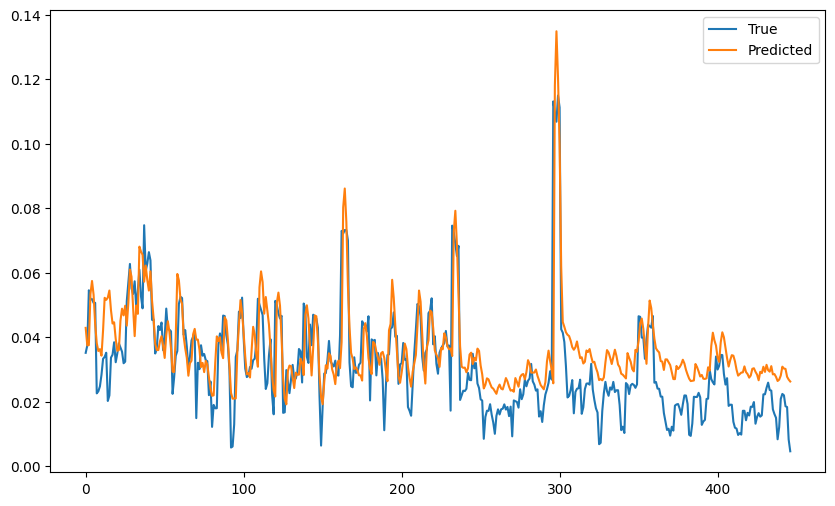

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(response_sequences_test, label='True')
plt.plot(prediction, label='Predicted')
plt.legend()
plt.show()

In [30]:
df["response"] = df["realized_vol"].shift(-5)

In [31]:
df.dropna(inplace=True)

In [32]:
df

,open,high,low,close,adjClose,changePercent,vwap,return,return_squared,realized_vol,h.1,h.2,h.3,h.4,h.5,response
0,55.56,55.96,54.66,55.49,54.90,-0.125999,55.37,-0.000180,3.246490e-08,0.027157,0.024855,0.024499,0.025081,0.025559,0.026015,0.012796
1,54.55,55.96,54.00,55.92,55.33,2.511456,55.29,0.007749,6.004923e-05,0.011820,0.023794,0.023641,0.024265,0.024793,0.025294,0.012510
2,56.25,56.57,55.80,56.02,55.43,-0.408889,56.13,0.001788,3.197906e-06,0.012290,0.022903,0.022759,0.023444,0.024023,0.024571,0.016716
3,55.90,56.25,55.33,55.74,55.16,-0.277286,55.78,-0.004998,2.498215e-05,0.013983,0.022079,0.022063,0.022789,0.023412,0.023998,0.016011
4,56.01,56.88,54.17,55.03,54.45,-1.758538,55.36,-0.012738,1.622493e-04,0.007689,0.021608,0.021873,0.022594,0.023231,0.023829,0.010583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,481.94,494.04,481.20,488.90,488.88,1.444162,488.05,0.011169,1.247368e-04,0.014962,0.022889,0.022938,0.023597,0.024168,0.024706,0.021960
1495,494.00,504.33,491.50,500.77,500.75,1.370443,498.87,0.024279,5.894695e-04,0.008307,0.023025,0.023771,0.024324,0.024853,0.025350,0.018554
1496,494.24,497.00,488.95,496.04,496.02,0.364199,494.00,-0.009445,8.921660e-05,0.012113,0.023198,0.023156,0.023805,0.024363,0.024889,0.018309
1497,496.55,499.99,480.98,481.11,481.09,-3.109456,487.36,-0.030098,9.059124e-04,0.020849,0.023636,0.024758,0.025220,0.025698,0.026146,0.008242


In [33]:
X = df[["return_squared", "realized_vol", "h.1","h.2","h.3","h.4","h.5"]]
y = df["response"]

In [34]:
def objective(trial):
    gamma = trial.suggest_loguniform('gamma', 1e-5, 1e2)
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    epsilon = trial.suggest_loguniform('epsilon', 1e-5, 1e2)
    
    svr_rbf = SVR(kernel='rbf', gamma=gamma, C=C, epsilon=epsilon)
    # svr_rbf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
    svr_rbf.fit(X.iloc[:n], y.iloc[:n])
    predictions = svr_rbf.predict(X.iloc[n:])
    mse = mean_squared_error(y.iloc[n:], predictions)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2024-04-25 06:32:24,826] A new study created in memory with name: no-name-d2c43718-e9ea-4905-9eec-68aba6e73175
[I 2024-04-25 06:32:24,895] Trial 0 finished with value: 0.00027348233700773316 and parameters: {'gamma': 0.78081762210078, 'C': 0.22132874957955437, 'epsilon': 1.812177425432058e-05}. Best is trial 0 with value: 0.00027348233700773316.
[I 2024-04-25 06:32:24,900] Trial 1 finished with value: 0.0017008210209289668 and parameters: {'gamma': 0.009668488955302819, 'C': 7.8972377667105125, 'epsilon': 0.5433535671357993}. Best is trial 0 with value: 0.00027348233700773316.
[I 2024-04-25 06:32:24,905] Trial 2 finished with value: 0.0017008210209289668 and parameters: {'gamma': 0.00010931957790304908, 'C': 0.0004097831480047524, 'epsilon': 0.6731253255435292}. Best is trial 0 with value: 0.00027348233700773316.
[I 2024-04-25 06:32:24,989] Trial 3 finished with value: 0.000329634396513708 and parameters: {'gamma': 0.0013758781394283919, 'C': 0.002636908519332932, 'epsilon': 0.00106

In [35]:
svr_rbf = SVR(kernel='rbf', **best_params)
svr_rbf.fit(X.iloc[:n], y.iloc[:n])
predictions = pd.DataFrame(svr_rbf.predict(X.iloc[n:]))
mean_squared_error(y.iloc[n:], predictions)

0.00024351534811557874

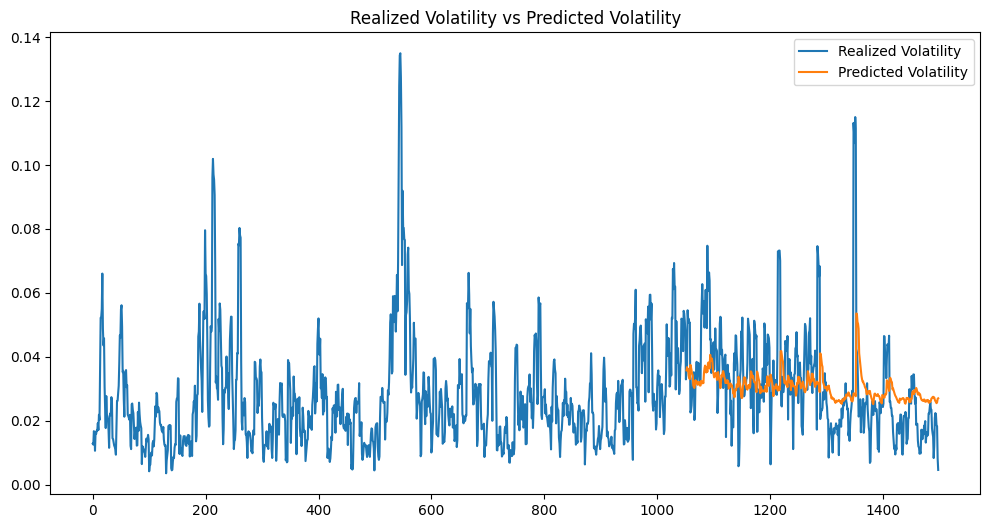

In [36]:
predictions.index = y.index[n:]
plt.figure(figsize=(12, 6))
plt.plot(y, label='Realized Volatility')
plt.plot(predictions, label='Predicted Volatility')
plt.title('Realized Volatility vs Predicted Volatility')
plt.legend()
plt.show()

In [ ]:
data